### Find blobs

In [1]:
from functools import partial

import igraph as ig
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

#### Main functions

In [2]:
import jax
import jax.numpy as jnp
import networkx as nx
import numpy as np


def jax_euclidean(matrix: np.ndarray) -> np.ndarray:
    """
    Calculate the element-wise absolute difference of each row in the matrix from the matrix itself.

    Parameters:
    - matrix (np.ndarray): Input matrix.

    Returns:
    - np.ndarray: Resulting matrix of absolute differences.
    """

    def _for_each(carry, row):
        return carry, jnp.abs((row - matrix))

    _, result = jax.lax.scan(_for_each, None, matrix)
    return result


def resolve_neighborhood(data: np.ndarray) -> np.ndarray:
    """
    Resolve neighborhood relationships in the input data based on a threshold.

    Parameters:
    - data (np.ndarray): Input thresholded data.
    Returns:
    - np.ndarray: Boolean array indicating neighborhood relationships.
    """
    data = jnp.array(data, dtype=np.float32)

    # Get index coordinates of values where the mask is true
    pairs = np.stack(np.where(data), axis=1)

    def _for_pair(carry, pair):
        x = jnp.abs(pair - pairs)
        # No difference in coordinate x_i - x_j can be greater than one
        # and at least one x_i has to be one for being a neighbor
        return carry, jnp.logical_and((x == 1).any(axis=1), ~(x > 1).any(axis=1))

    _, result = jax.lax.scan(_for_pair, None, pairs)

    return result, pairs


def return_labeled_blobs(data: np.ndarray, thr: float) -> np.ndarray:
    """
    Return labeled blobs in the input data based on neighborhood relationships.

    Parameters:
    - data (np.ndarray): Input data.
    - thr (float): Threshold value.

    Returns:
    - np.ndarray: Labeled blobs.
    """
    
    # Threshold data
    mask = data >= thr
    
    d, pairs = resolve_neighborhood(mask)

    G = nx.from_numpy_array(d)

    labels = np.zeros(d.shape[0], dtype=int)
    cc = sorted(nx.connected_components(G))

    for l, cc_ in enumerate(cc):
        idx = np.array(list(cc_))
        labels[idx] = l + 1

    # Create a labeled array
    labeled = np.array(mask, dtype=int)
    labeled[tuple(pairs.T)] = labels

    return labeled

In [3]:
def makeGaussian(size, fwhm=3, center=None):
    """Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4 * np.log(2) * ((x - x0) ** 2 + (y - y0) ** 2) / fwhm ** 2)

#### Example with 2D data

Generate some gaussian blobs in 2D and sum them toguether. So the ground truth is know.

In [4]:
n_blobs = 20
size = 100


centers = np.random.randint(0, size, size=(n_blobs, 2))

data = []
for center in centers:
    data += [makeGaussian(size, fwhm=10, center=center)]
data = np.sum(data, axis=0)

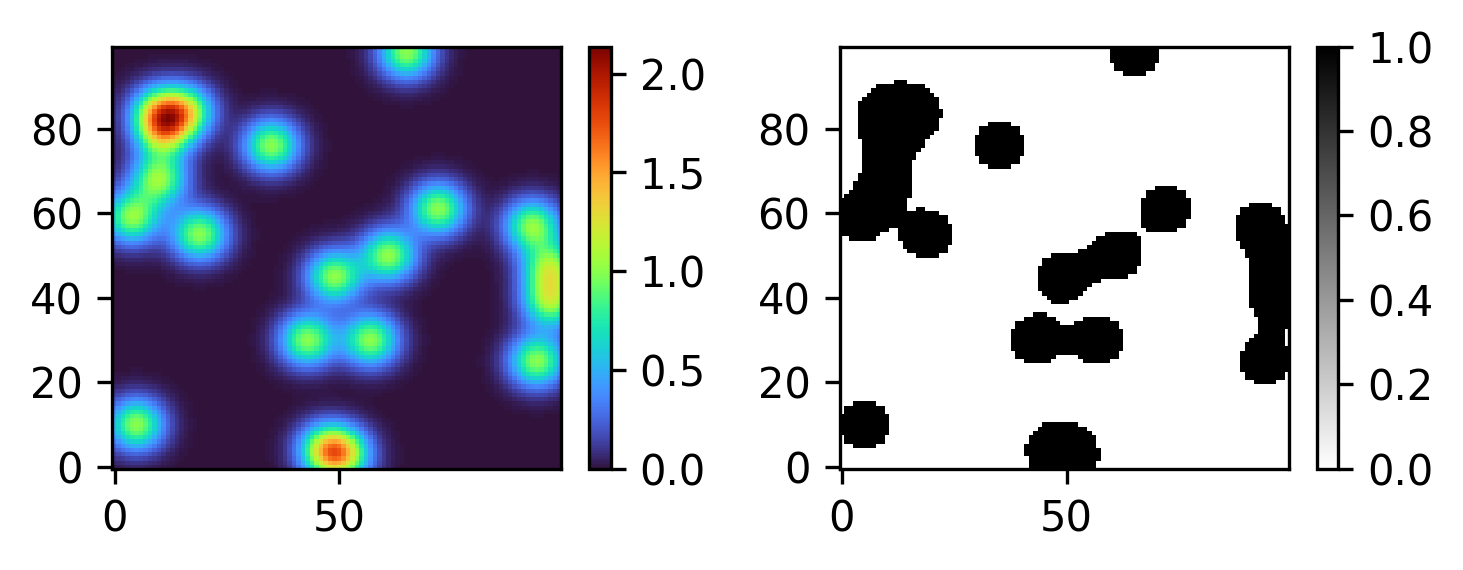

In [5]:
plt.figure(figsize=(5, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(data, aspect="auto", origin="lower", cmap="turbo")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(data > 0.4, aspect="auto", origin="lower", cmap="binary")
plt.colorbar()
plt.tight_layout()

In [6]:
# Create labeled image
labeled = return_labeled_blobs(data, .4)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


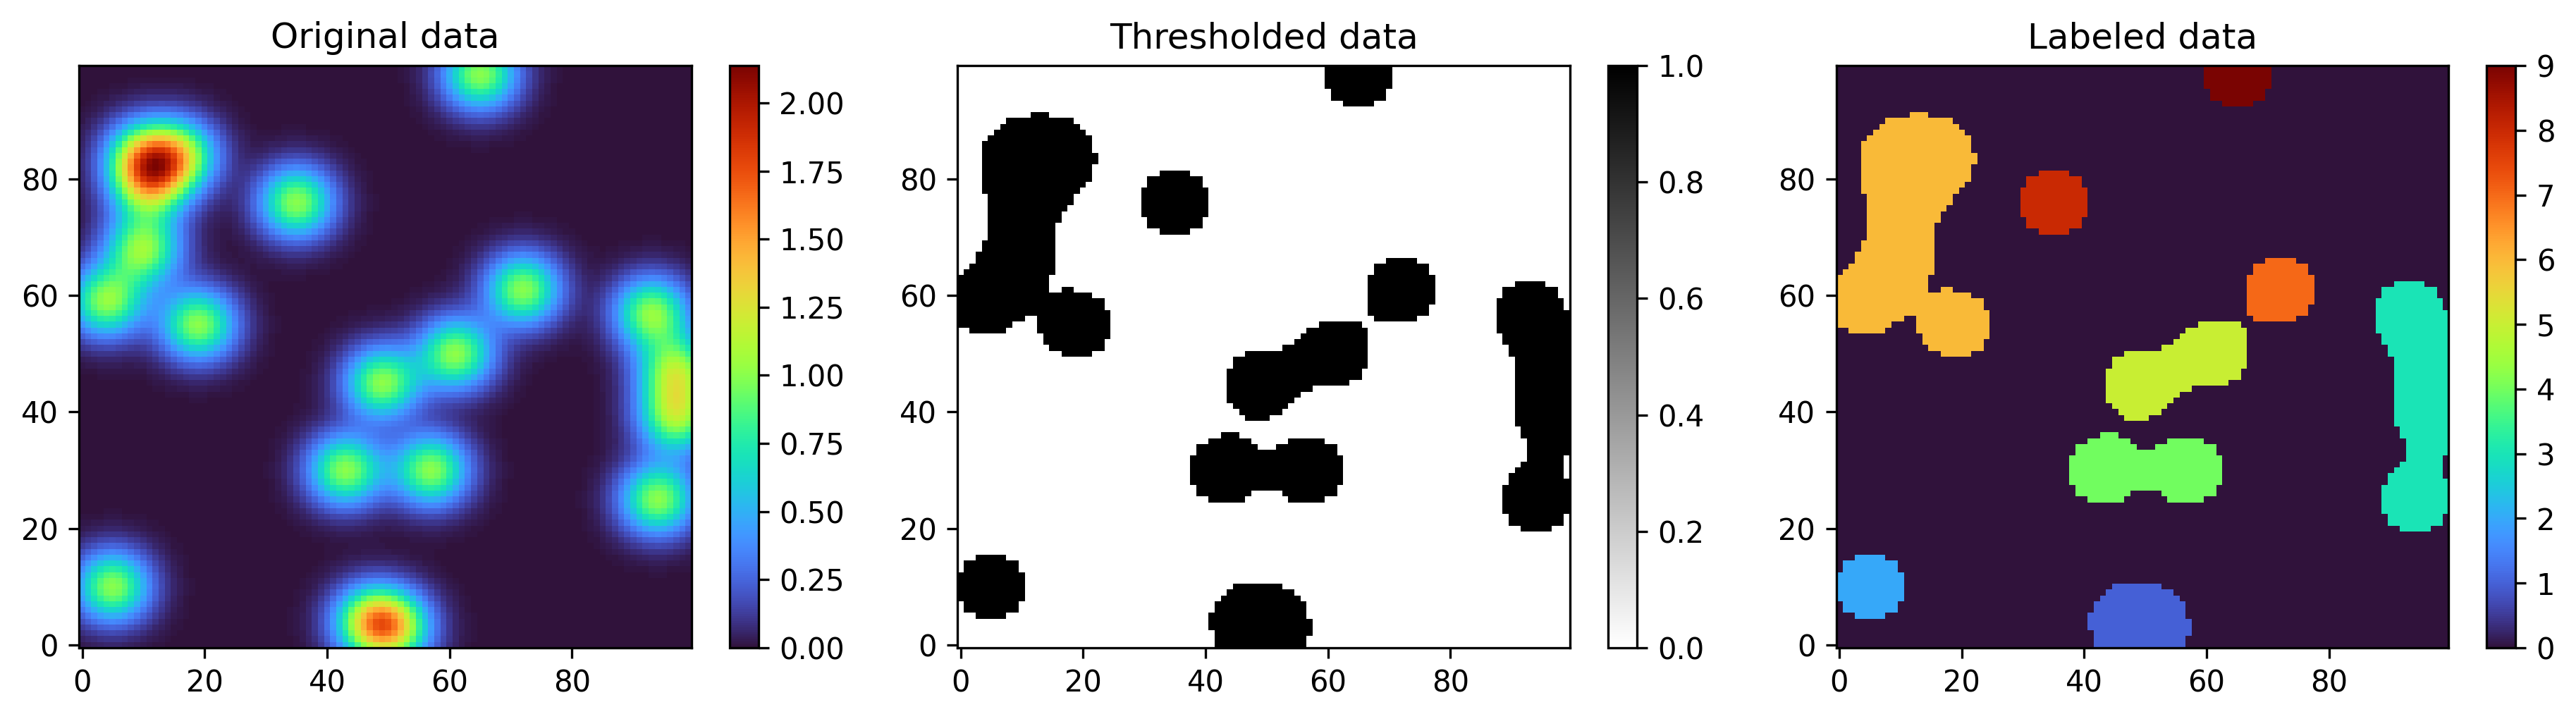

In [7]:
plt.figure(figsize=(12.5, 3.5), dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(data, aspect="auto", origin="lower", cmap="turbo")
plt.title("Original data")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(data > 0.4, aspect="auto", origin="lower", cmap="binary")
plt.title("Thresholded data")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(labeled, aspect="auto", origin="lower", cmap="turbo")
plt.colorbar()
plt.title("Labeled data")
plt.tight_layout()

#### Example with 3D data

Same as above, but here I stack a 5 2D maps to get a 3D matrix (for instance channels, time and frequency dimensions).

In [8]:
# Fewer but bigger blobs
n_blobs = 5
size = 100

temp = []
for i in range(5):
    centers = np.random.randint(0, size, size=(n_blobs, 2))

    data = []
    for center in centers:
        data += [makeGaussian(size, fwhm=20, center=center)]
    temp += [np.sum(data, axis=0)]
data = np.stack(temp)

In [46]:
def create_spherical_blob(radius, center, shape):
    """
    Create a spherical blob in a 3D matrix.

    Parameters:
    - radius (float): Radius of the spherical blob.
    - center (tuple): Center coordinates (x, y, z) of the spherical blob.
    - shape (tuple): Shape of the 3D matrix (depth, height, width).

    Returns:
    - np.ndarray: 3D matrix with a spherical blob.
    """
    x, y, z = np.ogrid[:shape[0], :shape[1], :shape[2]]
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    blob = (distance <= radius).astype(int)
    return blob

# Set the shape of the 3D matrix
matrix_shape = (20, 20, 20)

# Create two spherical blobs
blob1 = create_spherical_blob(radius=5, center=(8, 8, 8), shape=matrix_shape)
blob2 = create_spherical_blob(radius=5, center=(15, 15, 15), shape=matrix_shape)

# Combine the two blobs in the 3D matrix
data = blob1 + blob2

Text(0.5, 0, 'Z Axis')

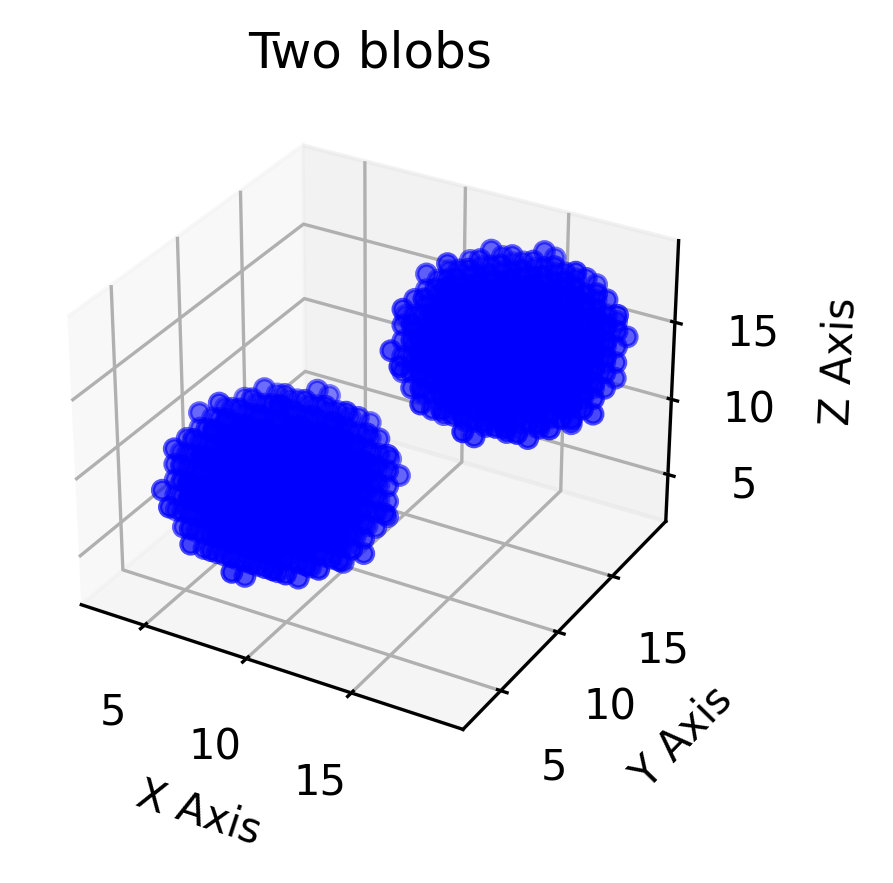

In [51]:
# Get the coordinates of non-zero elements in the matrix
nonzero_coords = np.transpose(np.nonzero(data))

# Visualize the 3D matrix
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
plt.title("Two blobs")

# Scatter plot for each non-zero element
ax.scatter(nonzero_coords[:, 2], nonzero_coords[:, 1], nonzero_coords[:, 0], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

In [52]:
# Create labeled image
labeled = return_labeled_blobs(data, .4)

In [14]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Labeled blobs')

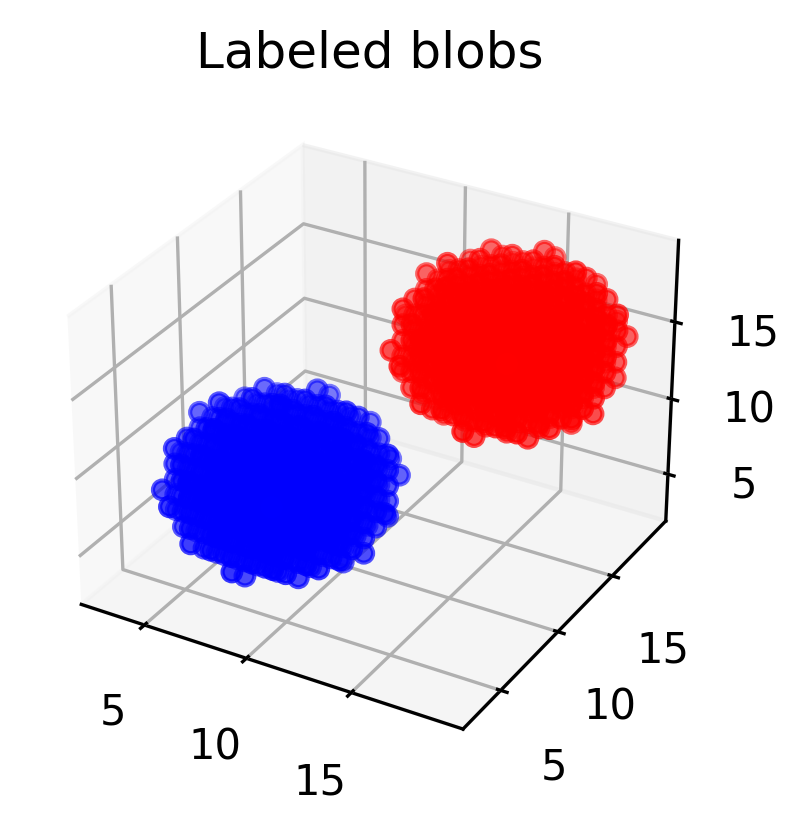

In [63]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(3, 3), dpi=300)
x, y, z = np.where(labeled==1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z, y, x, c='b', marker='o')

x, y, z = np.where(labeled==2)
ax.scatter(z, y, x, c='r', marker='o')
plt.title("Labeled blobs")